In [1]:
%load_ext rpy2.ipython

In [7]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


#### Read in sample metadata

In [3]:
%%R
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

#### Read in OTU table

In [4]:
%%R
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom") 

#### Add sample metadata to phyloseq object

In [5]:
%%R
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]


#### Get heavy fractions from physeq object

In [6]:
%%R
dna.density.min = 1.7125
#rna.density.min = 1.825

md = sample_data(physeq)
criterion = md$Density >= with(md, dna.density.min)

physeq.heavy = prune_samples(criterion, physeq)

In [7]:
%%R
physeq.heavy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 76 samples ]
sample_data() Sample Data:       [ 76 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]


#### Function for estimating fold change and standard error with DESeq2

In [8]:
%%R
get_l2fc = function(physeq.obj, Day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples(#physeq.md$RNA_DNA == RNA_DNA)&
                      (physeq.md$Day == Day), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

#### Function arguments

In [9]:
%%R
m = expand.grid(Day = c(3, 7, 14, 30))
m

  Day
1   3
2   7
3  14
4  30


#### mdply call with function arguments

In [10]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.heavy))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining, by = "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarnin

# A tibble: 7,620 x 11
     Day      OTU log2FoldChange     lfcSE       Rank1         Rank2
   <dbl>    <chr>          <dbl>     <dbl>      <fctr>        <fctr>
1      3    OTU.8      1.9203802 0.6166709    k__Fungi p__Ascomycota
2      3    OTU.5     -0.1829713 0.5039397    k__Fungi p__Ascomycota
3      3    OTU.2      1.2471580 0.3691561    k__Fungi p__Ascomycota
4      3    OTU.3     -0.2297602 0.3211446    k__Fungi p__Ascomycota
5      3  OTU.774      1.3177208 2.0688068    k__Fungi p__Zygomycota
6      3  OTU.240      0.8095619 1.0045908    k__Fungi p__Ascomycota
7      3   OTU.22      1.1055255 0.4719887    k__Fungi p__Zygomycota
8      3 OTU.1786             NA        NA k__Protista p__Ciliophora
9      3   OTU.85     -0.8309237 0.5905621    k__Fungi p__Ascomycota
10     3   OTU.26     -0.6338050 0.2423343    k__Fungi p__Ascomycota
# ... with 7,610 more rows, and 5 more variables: Rank3 <fctr>, Rank4 <fctr>,
#   Rank5 <fctr>, Rank6 <fctr>, Rank7 <fctr>


#### Finding l2fc threshold as defined by 1 sd away from the mean l2fc for RNA/DNA combined

In [11]:
%%R
summarise(ungroup(df.l2fc),
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

# A tibble: 1 x 1
   meanl2fc
      <dbl>
1 0.1269576


In [12]:
%%R
summarise(ungroup(df.l2fc),
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

# A tibble: 1 x 1
    sdl2fc
     <dbl>
1 2.154458


#### log2fold change threshold set at 2.3

#### Now get sparsity info for each OTU

In [13]:
%%R
mdf.heavy = tbl_df(psmelt(physeq.heavy))

In [14]:
%%R
sparsity.df = mdf.heavy %>%
    group_by(OTU, Day, RNA_DNA) %>%
    summarize(sparsity = sum(Abundance > 0) / length(Abundance)) %>%
    #filter(Treatment == "13CCPS") %>%
    select(OTU, Day, RNA_DNA, sparsity)

sparsity.df

Source: local data frame [7,620 x 4]
Groups: OTU, Day [7,620]

        OTU   Day RNA_DNA  sparsity
      <chr> <int>  <fctr>     <dbl>
1     OTU.1     3     DNA 1.0000000
2     OTU.1     7     DNA 1.0000000
3     OTU.1    14     DNA 1.0000000
4     OTU.1    30     DNA 1.0000000
5    OTU.10     3     DNA 1.0000000
6    OTU.10     7     DNA 1.0000000
7    OTU.10    14     DNA 1.0000000
8    OTU.10    30     DNA 1.0000000
9  OTU.1000     3     DNA 0.5263158
10 OTU.1000     7     DNA 0.6842105
# ... with 7,610 more rows


#### Add sparsity information to l2fc table

In [15]:
%%R
df.l2fc = left_join(df.l2fc, sparsity.df)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining, by = c("Day", "OTU")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


#### Add p-values to l2fc table

In [16]:
%%R
l2fc.threshold = 2.3
df.l2fc$p = with(df.l2fc, pnorm(log2FoldChange, l2fc.threshold, lfcSE, lower.tail = FALSE))

#### Plot sparsity threshold versus number of adjusted p-values less than FDR

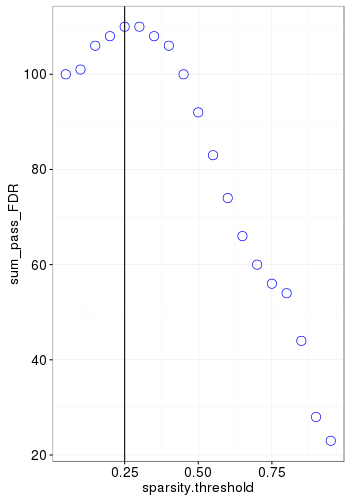

In [17]:
%%R -w 350 -h 500
FDR = 0.10

count_sig = function(df, sparsity.threshold) {
    d = df %>%
            filter(sparsity >= sparsity.threshold) %>%
            mutate(padj = p.adjust(p, method = "BH"))%>% 
            summarize(sum_pass_FDR = sum(padj <= FDR))
    d
}

thresh = seq(0.05, 0.95, 0.05)
names(thresh) = thresh

d.sparsity = ldply(thresh, count_sig, .id = "sparsity.threshold", df = df.l2fc)
d.sparsity$sparsity.threshold = as.numeric(as.character(d.sparsity$sparsity.threshold))

p = ggplot(d.sparsity, aes(x = sparsity.threshold, y = sum_pass_FDR))

#p = p + facet_wrap(~RNA_DNA, ncol = 1, scales = "free_y")

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(xintercept = 0.25)

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14),
              strip.text = element_text(size = 14),
              strip.background = element_blank())

p

#### Remove OTU/Day/RNA_DNA rows below sparsity threshold and add adjusted p-value to l2fc table 

In [18]:
%%R
sparsity.threshold = 0.25
df.l2fc = df.l2fc %>% 
    filter(sparsity >= sparsity.threshold) %>%
    mutate(padj = p.adjust(p, method = "BH"))
df.l2fc

# A tibble: 1,780 x 15
     Day     OTU log2FoldChange     lfcSE    Rank1         Rank2
   <dbl>   <chr>          <dbl>     <dbl>   <fctr>        <fctr>
1      3   OTU.8     1.92038019 0.6166709 k__Fungi p__Ascomycota
2      3   OTU.5    -0.18297135 0.5039397 k__Fungi p__Ascomycota
3      3   OTU.2     1.24715796 0.3691561 k__Fungi p__Ascomycota
4      3   OTU.3    -0.22976017 0.3211446 k__Fungi p__Ascomycota
5      3 OTU.240     0.80956187 1.0045908 k__Fungi p__Ascomycota
6      3  OTU.22     1.10552549 0.4719887 k__Fungi p__Zygomycota
7      3  OTU.85    -0.83092366 0.5905621 k__Fungi p__Ascomycota
8      3  OTU.26    -0.63380503 0.2423343 k__Fungi p__Ascomycota
9      3   OTU.7     2.84928575 0.4226111 k__Fungi p__Ascomycota
10     3  OTU.15    -0.02368472 0.3038414 k__Fungi p__Ascomycota
# ... with 1,770 more rows, and 9 more variables: Rank3 <fctr>, Rank4 <fctr>,
#   Rank5 <fctr>, Rank6 <fctr>, Rank7 <fctr>, RNA_DNA <fctr>, sparsity <dbl>,
#   p <dbl>, padj <dbl>


In [19]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [20]:
%%R
write.table(df.l2fc, "data/l2fc_UNITE.csv", row.names = FALSE, sep = ",")
df.l2fc

# A tibble: 1,780 x 15
     Day     OTU log2FoldChange     lfcSE    Rank1      Rank2           Rank3
   <dbl>   <chr>          <dbl>     <dbl>   <fctr>      <chr>           <chr>
1      3   OTU.8     1.92038019 0.6166709 k__Fungi Ascomycota  Orbiliomycetes
2      3   OTU.5    -0.18297135 0.5039397 k__Fungi Ascomycota Sordariomycetes
3      3   OTU.2     1.24715796 0.3691561 k__Fungi Ascomycota Sordariomycetes
4      3   OTU.3    -0.22976017 0.3211446 k__Fungi Ascomycota Sordariomycetes
5      3 OTU.240     0.80956187 1.0045908 k__Fungi Ascomycota Sordariomycetes
6      3  OTU.22     1.10552549 0.4719887 k__Fungi Zygomycota  Incertae sedis
7      3  OTU.85    -0.83092366 0.5905621 k__Fungi Ascomycota  Eurotiomycetes
8      3  OTU.26    -0.63380503 0.2423343 k__Fungi Ascomycota Sordariomycetes
9      3   OTU.7     2.84928575 0.4226111 k__Fungi Ascomycota            <NA>
10     3  OTU.15    -0.02368472 0.3038414 k__Fungi Ascomycota Dothideomycetes
# ... with 1,770 more rows, and 8 more va

In [21]:
%%R
df.l2fc = read.csv("data/l2fc_UNITE.csv", header = TRUE, sep = ",")

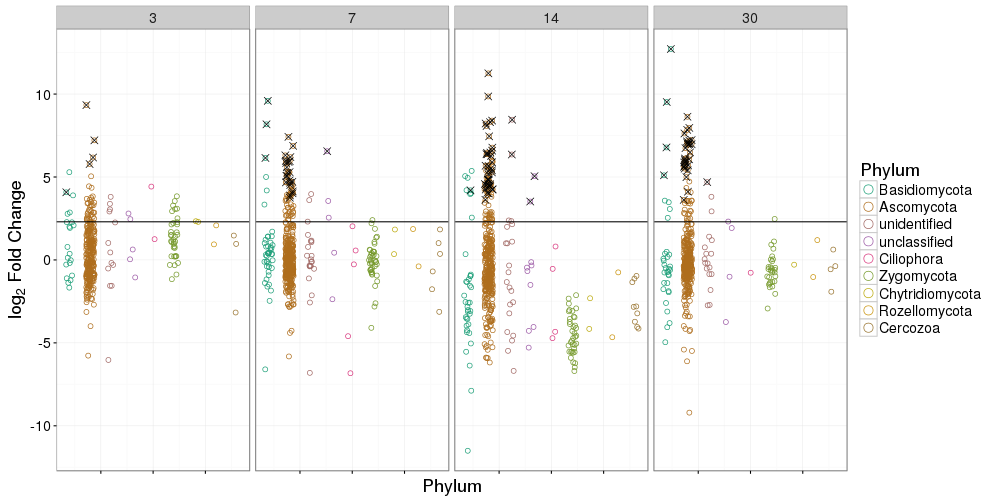

In [22]:
%%R -w 1000 -h 500
d = df.l2fc

FDR = 0.10
l2fc.threshold = 2.3

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)



M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 3)

p = p + geom_hline(yintercept = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=18)) 

p

In [23]:
%%R
ggsave(filename = "data/figs/l2fc_byphyla.pdf", plot = p, width = 12, height = 7)

In [24]:
%%R
sord = filter(df.l2fc, padj <=0.10) 
length(unique(sord$OTU))

[1] 80


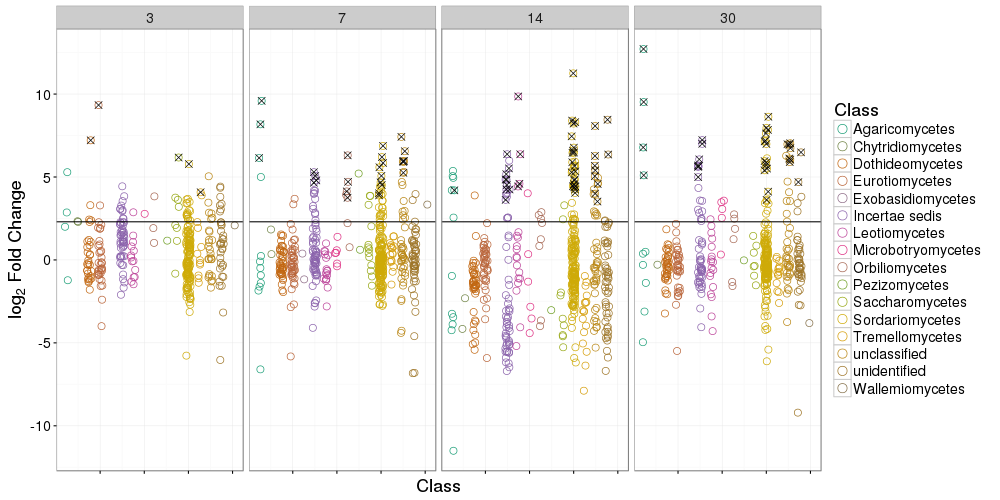

In [25]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 3)

p = p + geom_hline(yintercept = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=18)) 

p

In [26]:
%%R
ggsave(filename = "data/figs/l2fc_byclass.pdf", plot = p, width = 12, height = 7)

In [27]:
%%R
d.resp = filter(df.l2fc, padj <=0.10) %>% group_by(Rank3, Day) %>% summarise(counts = length(unique(OTU)))
d.resp %>% as.data.frame

             Rank3 Day counts
1   Agaricomycetes   7      3
2   Agaricomycetes  14      1
3   Agaricomycetes  30      4
4  Dothideomycetes   3      1
5   Eurotiomycetes   3      1
6   Incertae sedis   7      4
7   Incertae sedis  14      9
8   Incertae sedis  30      7
9    Leotiomycetes  14      4
10  Orbiliomycetes   7      4
11 Saccharomycetes   3      1
12 Sordariomycetes   3      1
13 Sordariomycetes   7      9
14 Sordariomycetes  14     21
15 Sordariomycetes  30     14
16 Tremellomycetes   3      1
17    unidentified  14      2
18    unidentified  30      2
19            <NA>   7      6
20            <NA>  14      8
21            <NA>  30      7


In [28]:
%%R
d.resp = filter(df.l2fc, padj <=0.10) %>% group_by(Rank3) %>% summarise(counts = length(unique(OTU)))
d.resp %>% as.data.frame

             Rank3 counts
1   Agaricomycetes      7
2  Dothideomycetes      1
3   Eurotiomycetes      1
4   Incertae sedis     11
5    Leotiomycetes      4
6   Orbiliomycetes      4
7  Saccharomycetes      1
8  Sordariomycetes     33
9  Tremellomycetes      1
10    unidentified      3
11            <NA>     14


In [29]:
%%R
d.r = filter(df.l2fc, padj <= 0.10)
print(length(unique(d.r$OTU)))
print(length(d.r$OTU))

[1] 80
[1] 110


In [30]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank3, Day) %>%
summarise(counts = n())

In [31]:
%%R
f2[is.na(f2)] = "unclassified"

In [32]:
%%R
filter(df.l2fc, padj <=0.10, Rank3 == "Agaricomycetes")

  Day      OTU log2FoldChange     lfcSE    Rank1         Rank2          Rank3
1   7 OTU.3191       6.147461 1.4999145 k__Fungi Basidiomycota Agaricomycetes
2   7  OTU.901       9.590183 1.3232004 k__Fungi Basidiomycota Agaricomycetes
3   7 OTU.1156       8.176723 1.2152613 k__Fungi Basidiomycota Agaricomycetes
4  14  OTU.361       4.197329 0.4499487 k__Fungi Basidiomycota Agaricomycetes
5  30  OTU.365      12.715494 1.3820401 k__Fungi Basidiomycota Agaricomycetes
6  30 OTU.3191       5.103487 0.9491578 k__Fungi Basidiomycota Agaricomycetes
7  30 OTU.1873       6.781895 1.2524283 k__Fungi Basidiomycota Agaricomycetes
8  30  OTU.454       9.520328 1.3897657 k__Fungi Basidiomycota Agaricomycetes
           Rank4               Rank5         Rank6                  Rank7
1 Cantharellales      Tulasnellaceae  unidentified      Tulasnellaceae sp
2    Sebacinales Sebacinales Group B  unidentified Sebacinales Group B sp
3    Sebacinales Sebacinales Group B  unidentified Sebacinales Group B sp
4 

In [33]:
%%R
mdf = psmelt(physeq.heavy)

In [34]:
%%R
filter(mdf, OTU %in% c("OTU.1156", "OTU.1873", "OTU.454", "OTU.901")) %>% 
group_by(OTU, Day, Treatment) %>% 
summarise(sumab = sum(Abundance)) %>%
as.data.frame()

        OTU Day Treatment sumab
1  OTU.1156   3    12CCPS     0
2  OTU.1156   3    13CCPS     0
3  OTU.1156   7    12CCPS     1
4  OTU.1156   7    13CCPS   235
5  OTU.1156  14    12CCPS    10
6  OTU.1156  14    13CCPS    33
7  OTU.1156  30    12CCPS    17
8  OTU.1156  30    13CCPS     0
9  OTU.1873   3    12CCPS     0
10 OTU.1873   3    13CCPS     0
11 OTU.1873   7    12CCPS     0
12 OTU.1873   7    13CCPS     0
13 OTU.1873  14    12CCPS     0
14 OTU.1873  14    13CCPS     0
15 OTU.1873  30    12CCPS     1
16 OTU.1873  30    13CCPS    68
17  OTU.454   3    12CCPS     0
18  OTU.454   3    13CCPS     3
19  OTU.454   7    12CCPS     0
20  OTU.454   7    13CCPS     0
21  OTU.454  14    12CCPS     0
22  OTU.454  14    13CCPS     0
23  OTU.454  30    12CCPS     0
24  OTU.454  30    13CCPS   197
25  OTU.901   3    12CCPS     0
26  OTU.901   3    13CCPS     1
27  OTU.901   7    12CCPS     0
28  OTU.901   7    13CCPS   348
29  OTU.901  14    12CCPS     0
30  OTU.901  14    13CCPS     0
31  OTU.

In [35]:
%%R
filter(mdf, OTU %in% c("OTU.534")) %>% 
group_by(OTU, Day, Treatment) %>% 
summarise(sumab = sum(Abundance)) %>%
as.data.frame()

      OTU Day Treatment sumab
1 OTU.534   3    12CCPS    21
2 OTU.534   3    13CCPS     0
3 OTU.534   7    12CCPS     0
4 OTU.534   7    13CCPS    62
5 OTU.534  14    12CCPS     0
6 OTU.534  14    13CCPS     0
7 OTU.534  30    12CCPS     0
8 OTU.534  30    13CCPS     0


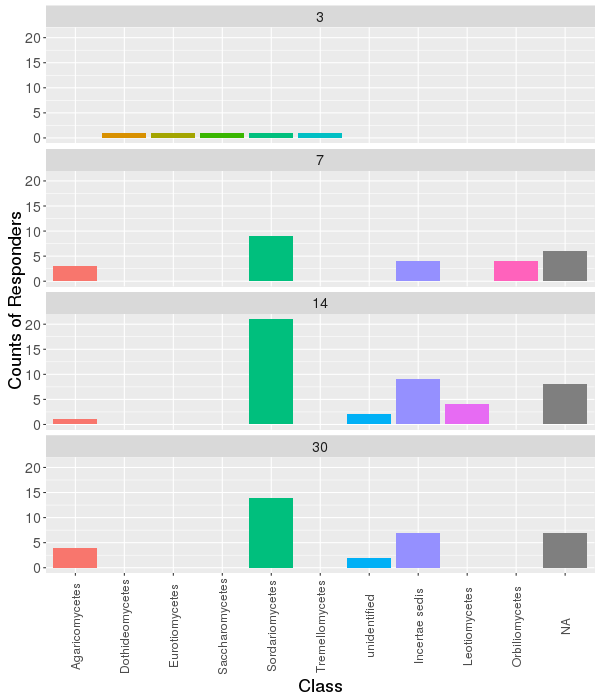

In [36]:
%%R -w 600 -h 700
f2$Rank3 <- factor(f2$Rank3, levels = f2$Rank3[order(f2$counts)])
p = ggplot(f2, aes(x = Rank3, y = counts, fill = Rank3)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Class")
p

In [37]:
%%R
hypo = filter(df.l2fc, Rank4 == "Hypocreales", padj <=0.10)

In [38]:
%%R
hypo2 = filter(df.l2fc, OTU %in% hypo$OTU)

In [39]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank4) %>%
summarise(counts = length(unique(OTU)))
f2

# A tibble: 16 x 2
                 Rank4 counts
                <fctr>  <int>
1           Agaricales      2
2            Boletales      1
3       Cantharellales      1
4  Cystofilobasidiales      1
5           Eurotiales      1
6           Helotiales      1
7          Hypocreales      6
8       Incertae sedis     14
9           Orbiliales      4
10        Pleosporales      1
11   Saccharomycetales      1
12         Sebacinales      3
13         Sordariales     26
14        unidentified      3
15          Xylariales      1
16                  NA     14


In [40]:
%%R
filter(df.l2fc, padj <=0.10, Rank3 == "Sordariomycetes") %>% group_by(Rank6) %>% 
summarise(counts = length(unique(OTU))) 


# A tibble: 9 x 2
          Rank6 counts
         <fctr>  <int>
1    Acremonium      1
2    Chaetomium      2
3      Humicola      1
4 Metacordyceps      1
5 Monographella      1
6     Podospora      1
7 Schizothecium      3
8  unidentified      9
9            NA     14


In [41]:
%%R
d.resp = filter(df.l2fc, padj <=0.10) %>% group_by(Rank4) %>% summarise(counts = length(unique(OTU)))
d.resp

# A tibble: 16 x 2
                 Rank4 counts
                <fctr>  <int>
1           Agaricales      2
2            Boletales      1
3       Cantharellales      1
4  Cystofilobasidiales      1
5           Eurotiales      1
6           Helotiales      1
7          Hypocreales      6
8       Incertae sedis     14
9           Orbiliales      4
10        Pleosporales      1
11   Saccharomycetales      1
12         Sebacinales      3
13         Sordariales     26
14        unidentified      3
15          Xylariales      1
16                  NA     14


In [42]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank3, Day) %>%
summarise(counts = n())

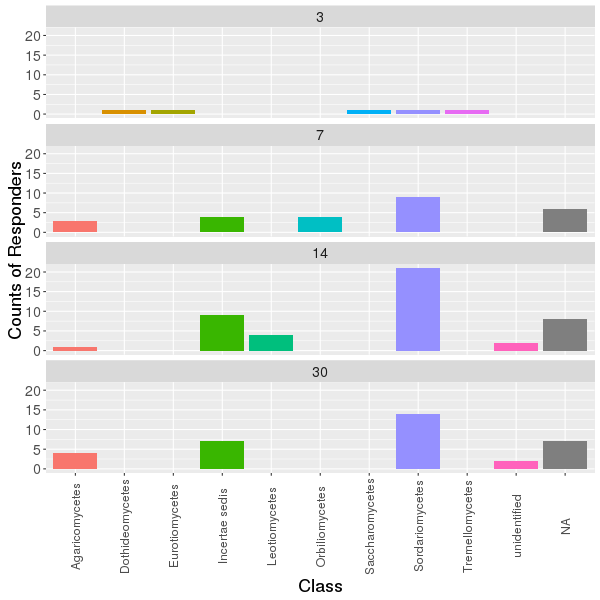

In [43]:
%%R -w 600 -h 600
f2$Rank5 <- factor(f2$Rank3, levels = f2$Rank3[order(f2$counts)])
p = ggplot(f2, aes(x = Rank3, y = counts, fill = Rank3)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Class")
p

In [44]:
%%R
(f2) %>% group_by(Rank5) %>% summarise(s = sum(counts)) 

# A tibble: 11 x 2
             Rank5     s
            <fctr> <int>
1   Agaricomycetes     8
2  Dothideomycetes     1
3   Eurotiomycetes     1
4  Saccharomycetes     1
5  Sordariomycetes    45
6  Tremellomycetes     1
7     unidentified     4
8   Incertae sedis    20
9    Leotiomycetes     4
10  Orbiliomycetes     4
11              NA    21


In [103]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank3, Rank6, Rank7) %>%
summarise(counts = n())

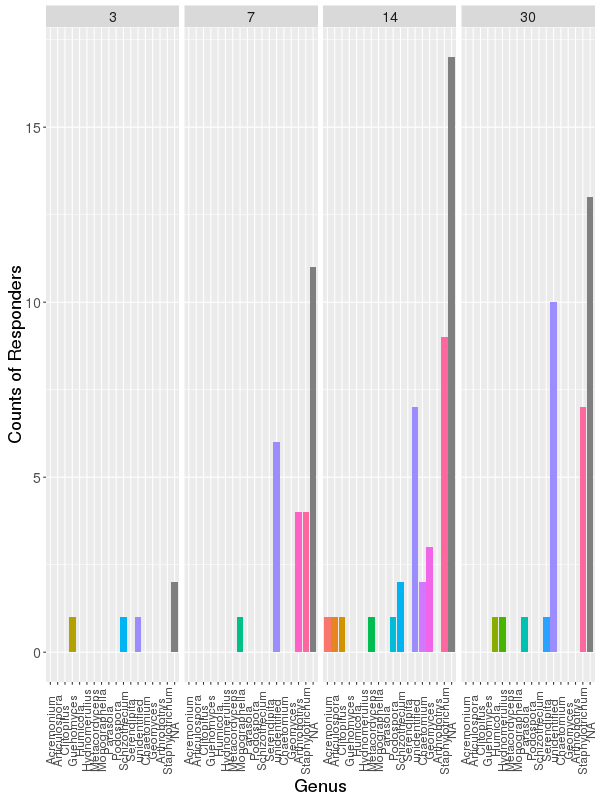

In [47]:
%%R -w 600 -h 800
f2$Rank6 <- factor(f2$Rank6, levels = f2$Rank6[order(f2$counts)])
p = ggplot(f2, aes(x = Rank6, y = counts, fill = Rank6)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_grid(~Day, scales = 'free_y')
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Genus")
p

In [48]:
%%R
ggsave(filename = "data/figs/respbyGenus.pdf", plot = p, width = 6, height = 7)

In [49]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank7, Day) %>%
summarise(counts = n())

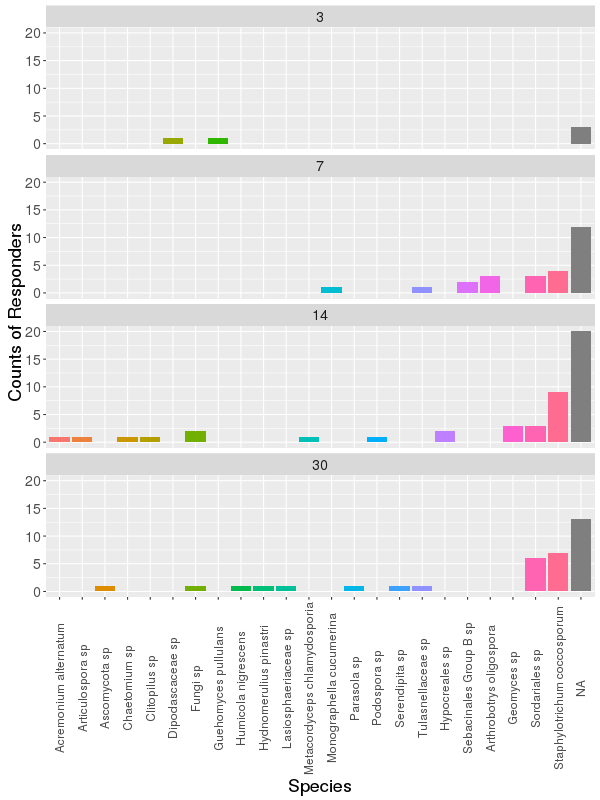

In [50]:
%%R -w 600 -h 800
f2$Rank7 <- factor(f2$Rank7, levels = f2$Rank7[order(f2$counts)])
p = ggplot(f2, aes(x = Rank7, y = counts, fill = Rank7)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Species")
p

In [51]:
%%R
ggsave(filename = "data/figs/respbyGenus.pdf", plot = p, width = 6, height = 7)

In [52]:
%%R
ggsave(filename = "data/figs/responders_hist_byClass.pdf", plot = p, width = 6, height = 7)

In [53]:
%%R

#OTUS that are responders by day
Day3 = filter(df.l2fc, Day == 3, padj <=0.10)
Day7 = filter(df.l2fc, Day == 7, padj <=0.10)
Day14 = filter(df.l2fc, Day == 14, padj <=0.10)
Day30 = filter(df.l2fc, Day == 30, padj <=0.10)

print(length(Day3$OTU))
print(length(Day7$OTU))
print(length(Day14$OTU))
print(length(Day30$OTU))


[1] 5
[1] 26
[1] 45
[1] 34


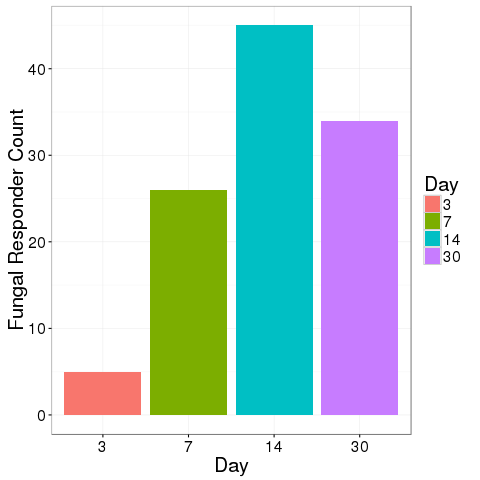

In [54]:
%%R
d = df.l2fc %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Fungal Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme(text = element_text(size=20))


px

In [55]:
%%R
ggsave(filename = "data/figs/l2fc_histogram_fungi.pdf", plot = px, width = 6, height = 6)

In [56]:
%%R
l2fc.df = tbl_df(read.table("/home/ashley/succ-C-DNASIP/data/l2fc_table.csv",
           sep = ",",
           header = TRUE))
l2fc.df = filter(l2fc.df, Treatment == "13CCPS")

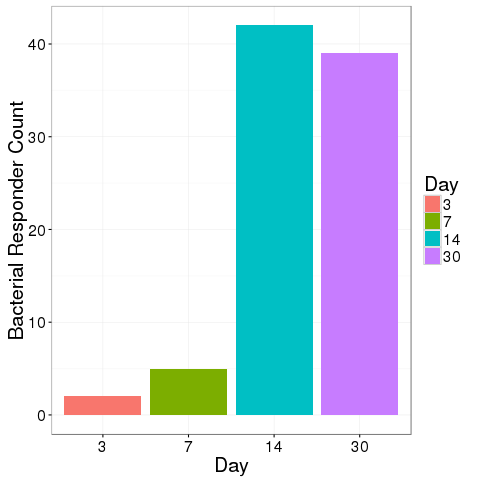

In [57]:
%%R
d = l2fc.df %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Bacterial Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme(text = element_text(size=20))


px

In [58]:
%%R
ggsave(filename = "data/figs/l2fc_histogram_bacteria.pdf", plot = px, width = 6, height = 6)

In [59]:
%%R
library(tidyr); library(magrittr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘tidyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:reshape2’:

    smiths


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:IRanges’:

    expand


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘magrittr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:tidyr’:

    extract


  res = super(Function, self).__call__(

In [60]:
%%R
data = data.frame(Day = c(0, 3, 7, 14, 30),
                  cellulose = c(100, 88.7, 78.8, 62.4, 39.8)) %>%
    gather(Substrate, "Percent left", -Day) %>%
    na.omit
    
data

  Day Substrate Percent left
1   0 cellulose        100.0
2   3 cellulose         88.7
3   7 cellulose         78.8
4  14 cellulose         62.4
5  30 cellulose         39.8


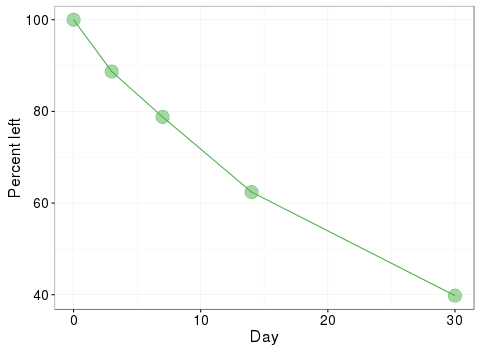

In [61]:
%%R -h 350
p = ggplot(data, aes(x = Day, y = `Percent left`, color = Substrate))

p = p + geom_point(size = 6, alpha = 0.5)
p = p + geom_line()
p = p + labs(x = "Day")
p = p + scale_color_manual(values = c("#4daf4a", "#377eb8"))
p = p + theme_bw()
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 16), 
              legend.text = element_text(size = 14), 
              legend.title = element_text(size = 16))
p = p + guides(color = FALSE)

p

In [62]:
%%R
ggsave(filename = "data/figs/13C-CelluloseLeft.pdf", plot = p, width = 5, height = 4)

In [63]:
%%R
library(stats)

In [64]:
%%R
s <- seq(from = 1.60, to = 1.74, by = 0.0005)
a = rnorm(s,1.68, 0.05)
b = rnorm(s,1.70, 0.05)

In [65]:
%%R
val = "A"
a2 = data.frame(a, val)

In [66]:
%%R
val = "B"
b2 = data.frame(b, val)

In [67]:
%%R
colnames(b2)[colnames(b2)=="b"] <- "a"

In [68]:
%%R
ab = rbind(a2,b2)
#ab$seq = s

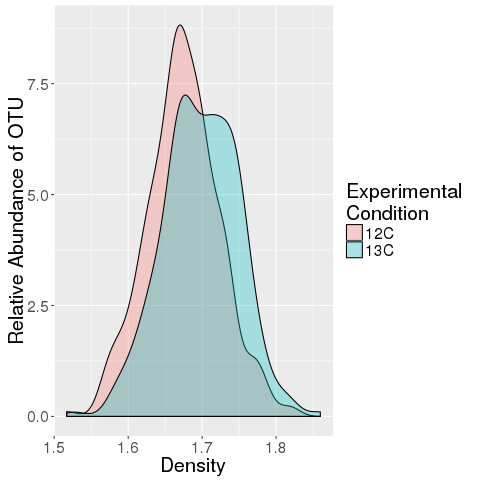

In [69]:
%%R
p = ggplot(ab, aes(x=a, fill=val)) + geom_density(alpha=.3) + ylab("Relative Abundance of OTU") + xlab("Density") +
 theme(text = element_text(size=20)) + scale_fill_discrete(name="Experimental\nCondition",
                         labels=c("12C", "13C"))

p



In [70]:
%%R
ggsave(filename = "data/figs/Densitydist_schematic.pdf", plot = p, width = 6, height = 4)

In [71]:
%%R
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank7) 

In [72]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder/unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "Responder"

In [73]:
%%R
responders = filter(new_df.l2fc, Resp_status == "Responder")

In [74]:
%%R
resp = filter(new_df.l2fc, OTU %in% responders$OTU)

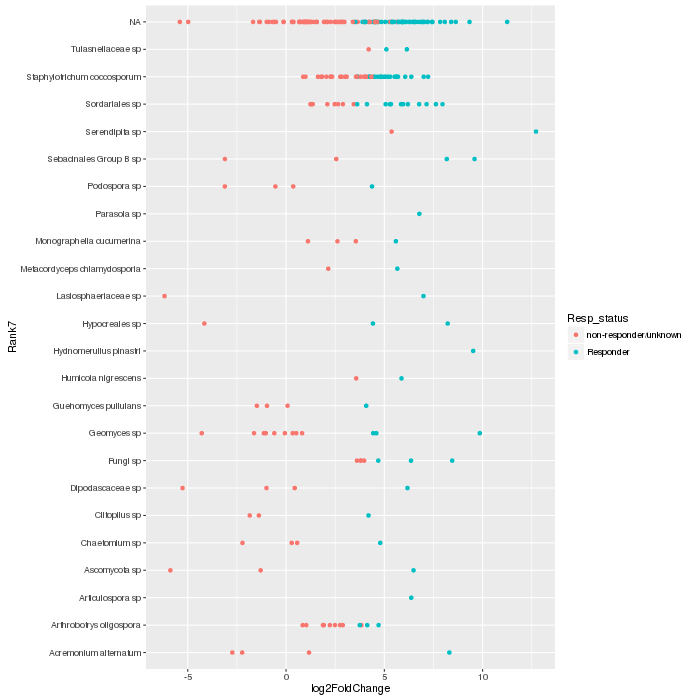

In [75]:
%%R -w 700 -h 700
p = ggplot(resp, aes(log2FoldChange, Rank7))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

In [76]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank6))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Rank6' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 26 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error in eval(expr, envir, enclos) : object 'Rank6' not found


## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")